# Speech To Text for Cascaded Models Demo

This Jupyter Notebook is designed to demonstrate the application of cascading architectures in Speech-to-Text (STT) models. It includes preprocessing of audio data, feature extraction, and the utilization of deep learning models for accurate speech recognition. The notebook is structured to guide through the steps involved in processing and transcribing speech using advanced neural network techniques.


## Data Preprocessing (MFCC Extraction)

This notes walks you through the steps taken to extract MFCCs from an audio data.

Ref:
- https://www.youtube.com/watch?v=WJI-17MNpdE
- https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

In [1]:
%pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchtext==0.14.1 torchaudio==0.13.1 torchdata==0.5.1 --extra-index-url https://download.pytorch.org/whl/cu117 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 501.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 40.5 MB/s eta 0:00:00


In [2]:
!pip install wandb --quiet
!pip install python-Levenshtein -q
!git clone --recursive https://github.com/parlance/ctcdecode.git
!pip install wget -q
%cd ctcdecode
!pip install . -q
%cd ..

!pip install torchsummaryX -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 18.9 MB/s eta 0:00:00
Cloning into 'ctcdecode'...
remote: Enumerating objects: 1102, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 1102 (delta 16), reused 32 (delta 14), pack-reused 1063
Receiving objects: 100% (1102/1102), 782.27 KiB | 13.72 MiB/s, done.
Resolving deltas: 100% (529/529), done.
Submodule 'third_party/ThreadPool' (https://github.com/progschj/ThreadPool.git) registered for path 'third_party/ThreadPool'
Submodule 'third_party/kenlm' (https://github.c

In [3]:
!pip install torch accelerate torchaudio datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 22.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [4]:
!pip install torchsummaryX -q

In [5]:
import os
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
from datasets import load_dataset, Audio
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummaryX import summary
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
# imports for decoding and distance calculation
import ctcdecode
import Levenshtein
from ctcdecode import CTCBeamDecoder

In [6]:
from torch.nn import TransformerEncoder, TransformerDecoder, TransformerEncoderLayer, TransformerDecoderLayer

### To download the dataset, it is important to log in to huggingface

In [7]:
from huggingface_hub import notebook_login

notebook_login()

### We visualize an example waveform, it's spectrogram (MFCC), and text transcription

In [8]:
def plot_audio_signal(time, signal):
  # Visualize the signal in raw wav form
  plt.figure(figsize=(16,4))
  plt.plot(time, signal)
  plt.grid()
  plt.show()


In [9]:
# Load Swahili Voice Data from Common Voice
train_data = load_dataset("mozilla-foundation/common_voice_13_0", "rw", split="train", streaming=True, trust_remote_code=True).shuffle()
train_data = train_data.cast_column("audio", Audio(sampling_rate=48000))
# stream_data = stream_data.cast_column("audio", Audio(sampling_rate=48_000))
en_sample = next(iter(train_data))["audio"]["array"]
# samples = stream_data.cast_column("audio", Audio(sampling_rate=16000))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Reading metadata...: 1003023it [01:21, 12371.86it/s]


Reading metadata...: 1003023it [00:11, 83903.22it/s]


Ariko yareka kubyara keretse nkinyanja


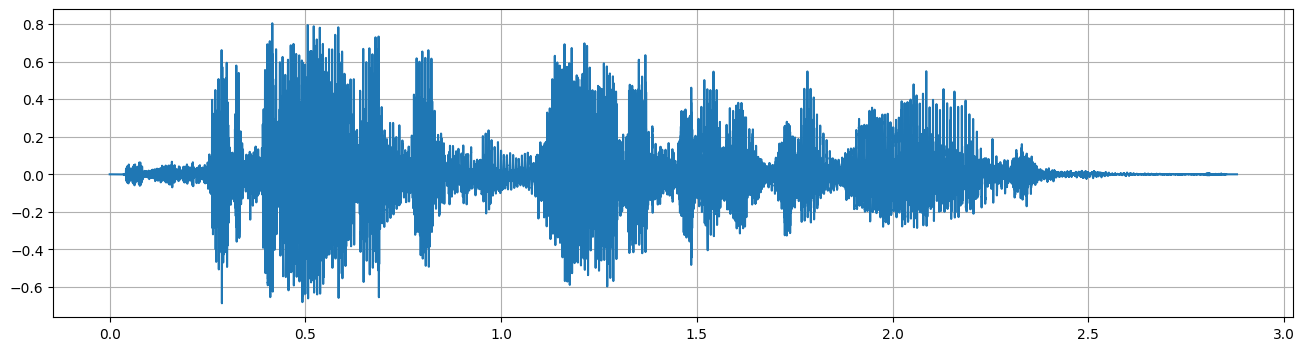

(27, 271)


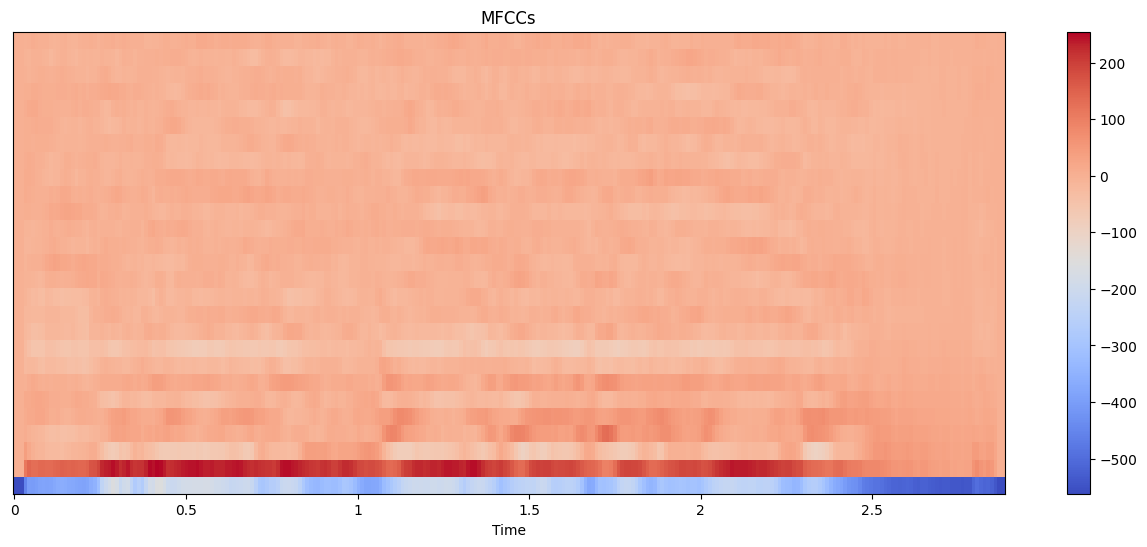

In [ ]:
for sample in train_data:
    # Here you can process each sample. For example, printing the sample.
    # print(sample['audio']['array'].shape) #['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant']
    print(sample['sentence'])
    sample_rate = sample['audio']['sampling_rate']
    signal = sample['audio']['array']
    # signal = sample['audio']
    duration = librosa.get_duration(y=signal, sr=sample_rate)
    time = np.arange(0, duration, 1/sample_rate)
    plot_audio_signal(time[:], signal) # I have no idea why the time array seems bigger than than the signal, I had to subtract to get the same dimension
    # Extracting mfccs
    mfccs = librosa.feature.mfcc(y=signal, n_mfcc=27, sr=sample_rate)
    print(mfccs.shape)
    # Visuzlize MFCCs
    plt.figure(figsize=(16,6))
    librosa.display.specshow(mfccs, x_axis="time", sr=sample_rate) # x_axis: time of audio & y_axis: mfcc coefficients
    plt.colorbar()
    plt.title("MFCCs")
    plt.show()

    break

### We also load validation data

In [10]:
val_data = load_dataset("mozilla-foundation/common_voice_13_0", "rw", split="validation", streaming=True, trust_remote_code=True).shuffle()
val_data = val_data.cast_column("audio", Audio(sampling_rate=48000))
# stream_data = stream_data.cast_column("audio", Audio(sampling_rate=48_000))
en_sample = next(iter(val_data))["audio"]["array"]
# samples = stream_data.cast_column("audio", Audio(sampling_rate=16000))

Reading metadata...: 15987it [00:01, 11315.43it/s]


In [ ]:
en_sample = next(iter(val_data))["audio"]["array"]

Reading metadata...: 15987it [00:00, 40607.76it/s]


In [56]:
from scipy.io import wavfile
wavfile.write("0.wav", 48000, en_sample.astype(np.float32))

In [52]:
texts_lists_sample = []

In [53]:
for sample_idx, sample in enumerate(val_data):
          # here we get the sentences.
          sentence = sample['sentence']
          texts_lists_sample.append(sentence)
          if sample_idx==5:
            break

Reading metadata...: 15987it [00:00, 34954.50it/s]


In [54]:
texts_lists_sample

['Mbasha kumesa nkamenya aho umugozi nanikaho imyenda uri;',
 'abantu bari ku Kibuga cy’Indege ari benshi',
 'cyane aramutonganya arangije yikoza hanze',
 'Intumbi zabo zizarambarara mu nzira nyabagendwa yo mu mudugudu munini',
 'ari amakimbirane yo mu muryango',
 'yari yakuwe imbere ya Yehova']

In [46]:
next(iter(val_data))

Reading metadata...: 15987it [00:00, 30623.70it/s]


'Mbasha kumesa nkamenya aho umugozi nanikaho imyenda uri;'

In [57]:
for sample_idx, sample in enumerate(val_data):
          # Here you can process each sample. For example, printing the sample.
          # print(sample['audio']['array'].shape) #['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant']
          sample_rate = sample['audio']['sampling_rate']
          signal = sample['audio']['array']
          wavfile.write(f"{sample_idx}.wav", 48000, signal.astype(np.float32))
          print
          if sample_idx==5:
            break

Reading metadata...: 15987it [00:00, 27943.45it/s]


### We define a vocabulary, for text characters

In [11]:
# Generate a vocabulary consisting of upper case, lower case alphabets and punctuations
vocabulary = ["<pad>"] + list(string.ascii_letters + string.punctuation) + [" "]
print("Vocabulary:", vocabulary)


Vocabulary: ['<pad>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', ' ']


In [12]:
vocabulary.index(" ")

85

### We define our custom audio dataset pytorch object

In [13]:
class AudioDataset(torch.utils.data.Dataset):

    def __init__(self, stream_data = train_data, vocabulary = vocabulary):
        print(stream_data)
    # def __init__(self, stream_data = augmented_dataset, vocabulary = vocabulary):
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''

        # Load the directory and all files in them

        self.vocabulary = vocabulary
        def remove_unwanted_chars(A, B):
          result = ""
          for char in A:
              if char in B:
                  result += char
          return result

        self.mfccs, self.transcripts = [], []


        for sample_idx, sample in enumerate(stream_data):
          # Here you can process each sample. For example, printing the sample.
          # print(sample['audio']['array'].shape) #['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant']
          sample_rate = sample['audio']['sampling_rate']
          signal = sample['audio']['array']
          mfcc = librosa.feature.mfcc(y=signal, n_mfcc=27, sr=sample_rate)
          # print(mfcc.shape)
          mfcc = mfcc.T
          mfcc = (mfcc - mfcc.mean(axis=0))/mfcc.std(axis=0)
          self.mfccs.append(mfcc.tolist())
          transcript = sample['sentence'].replace('’',"'").replace('“','"').replace('”','"')
          transcript = remove_unwanted_chars(transcript, self.vocabulary)
          self.transcripts.append([self.vocabulary.index(i) for i in transcript])
          if sample_idx == 32:
            break
        #TODO
        # WHAT SHOULD THE LENGTH OF THE DATASET BE?
        self.length = len(self.mfccs)

        assert len(self.mfccs) == len(self.transcripts)

        print('AUDIODATASET LOADED ...')

    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        mfcc = self.mfccs[ind]
        transcript = self.transcripts[ind]

        return torch.FloatTensor(mfcc), torch.tensor(transcript)
        # raise NotImplemented


    def collate_fn(self,batch):
        '''
        '''
        # print("batch shape:", batch[0][0].shape)
        # batch of input mfcc coefficients
        batch_mfcc = [i[0] for i in batch] # TODO
        # batch of output phonemes
        batch_transcript = [i[1] for i in batch] # TODO

        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first)
        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True) # TODO
        lengths_mfcc = [len(i) for i in batch_mfcc] # TODO

        batch_transcript_pad = pad_sequence(batch_transcript, batch_first = True, padding_value=self.vocabulary.index("<pad>")) # TODO
        lengths_transcript = [len(i) for i  in batch_transcript] # TODO

        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_mfcc_pad, batch_transcript_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)

Datasets instantiation:

In [14]:
train_dataset   = AudioDataset()
val_dataset   = AudioDataset(val_data)
# test_dataset    = AudioDataset()

IterableDataset({
    features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
    n_shards: 26
})


Reading metadata...: 1003023it [00:14, 66868.32it/s]


AUDIODATASET LOADED ...
IterableDataset({
    features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
    n_shards: 1
})


Reading metadata...: 15987it [00:00, 66820.00it/s]


AUDIODATASET LOADED ...


In [15]:
config ={
    'epochs'            : 30,
    'batch_size'        : 8,   # Initially it was 64 .... Increase if your device can handle it
    'lr'                : 2e-3,
    'encoder dropout'   : 0.25,
    'decoder dropout'   : 0.15,
    'lstm dropout'      : 0.25,
    'factor'            : 0.5,
    'sc_mode'           : 'min',
    'patience'          : 3,
    'sc_threshold'      : 1e-3,
    'threshold mode'    : 'rel',
    'beam_width'        : 5 ,
    'test_beam_width'   : 2
}

In [16]:
# train_dataset[0]

In [17]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, num_workers=2,
                                           batch_size =config['batch_size'],pin_memory=True, shuffle=True, collate_fn= train_dataset.collate_fn)#TODO

val_loader = torch.utils.data.DataLoader(dataset = val_dataset, num_workers=2,
                                           batch_size =config['batch_size'],pin_memory=True, shuffle=True, collate_fn= val_dataset.collate_fn)#TODO


In [18]:
print("Batch size: ", config['batch_size'])
print("Train dataset samples = {}, batches = {}".format(train_dataset.__len__(), len(train_loader)))
print("Validation dataset samples = {}, batches = {}".format(val_dataset.__len__(), len(val_loader)))

Batch size:  8
Train dataset samples = 33, batches = 5
Validation dataset samples = 33, batches = 5


In [19]:
# sanity check
for data in train_loader:
    x, y, lx, ly = data
    print(x.shape, y.shape, lx.shape, ly.shape)
    break

torch.Size([8, 876, 27]) torch.Size([8, 108]) torch.Size([8]) torch.Size([8])


In [20]:
for data in val_loader:
    x, y, lx, ly = data
    print(x.shape, y.shape, lx.shape, ly.shape)
    break

torch.Size([8, 804, 27]) torch.Size([8, 79]) torch.Size([8]) torch.Size([8])


### We define our own neural net


In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda



Pyramid Bi-LSTM (pBLSTM)


In [22]:
# Utils for network
torch.cuda.empty_cache()

class PermuteBlock(torch.nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)

In [23]:
class pBLSTM(torch.nn.Module):

    '''
    Pyramidal BiLSTM 
    '''

    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()

        self.blstm = nn.LSTM(input_size=2*input_size,hidden_size=hidden_size,num_layers=1,batch_first=True,bidirectional=True)# TODO: Initialize a single layer bidirectional LSTM with the given input_size and hidden_size

    def forward(self, x_packed): # x_packed is a PackedSequence

         

        x_pad, x_seq_len = pad_packed_sequence(x_packed, batch_first= True)
        x_trunc, x_len = self.trunc_reshape(x_pad, x_seq_len)
        x_packed = pack_padded_sequence(x_trunc, x_len, batch_first= True, enforce_sorted= False)
        output, (h_n, c_n) = self.blstm(x_packed)


        return output

    def trunc_reshape(self, x, x_lens):
         

        if x.shape[1]%2 != 0:
          x = x[:,:-1,:]
          x_lens -= 1
        x = x.reshape((x.shape[0],x.shape[1]//2, x.shape[2]*2))
        x_lens = x_lens//2
        return x, x_lens



In [24]:
from torch.autograd import Variable
class LockedDropout(nn.Module):
  def __init__(self, dropout):
    super().__init__()
    self.dropout = dropout

  def forward(self, x):
    if not self.training or not self.dropout:
      return x
    x_unpacked, x_lens = pad_packed_sequence(x, batch_first= True)
    m = x.data.new(1, x_unpacked.size(1), x_unpacked.size(2)).bernoulli_(1 - self.dropout)
    mask = Variable(m, requires_grad= False) / (1 - self.dropout)
    mask = mask.expand_as(x_unpacked)
    out = mask * x_unpacked
    return pack_padded_sequence(out, lengths= x_lens, batch_first= True, enforce_sorted= False)

In [25]:
class Encoder(torch.nn.Module):
    '''
    The Encoder takes utterances as inputs and returns latent feature representations
    '''
    def __init__(self, input_size, encoder_hidden_size):
        super(Encoder, self).__init__()


        self.embedding = torch.nn.Sequential(
            PermuteBlock(),
            torch.nn.Conv1d(in_channels= 27, out_channels= 27, kernel_size= 7, padding= 3),
            torch.nn.GELU(),
            PermuteBlock()
        )# CNN.
        self.BLSTMs = torch.nn.LSTM(input_size=27, hidden_size= encoder_hidden_size, num_layers=3, batch_first= True, bidirectional= True, dropout= config['lstm dropout'])

        self.pBLSTMs = torch.nn.Sequential( #  ?
            pBLSTM(encoder_hidden_size * 2, encoder_hidden_size),
            LockedDropout(config['encoder dropout']),
            pBLSTM(encoder_hidden_size * 2, encoder_hidden_size),
            LockedDropout(config['encoder dropout'])
        )

    def forward(self, x, x_lens):
        x_out = self.embedding(x)
        x_out = pack_padded_sequence(x_out, x_lens, batch_first= True, enforce_sorted= False)
        x_blstm, (h_n, c_n) = self.BLSTMs(x_out)
        x_pblstm = self.pBLSTMs(x_blstm)
        encoder_outputs, encoder_lens = pad_packed_sequence(x_pblstm, batch_first= True)
        # 

        return encoder_outputs, encoder_lens

Decoder

In [26]:
class Decoder(torch.nn.Module):

    def __init__(self, embed_size, output_size= 41):
        super().__init__()

        self.mlp = torch.nn.Sequential(
            PermuteBlock(), torch.nn.BatchNorm1d(2*embed_size), PermuteBlock(),
            #  size
            torch.nn.Linear(2 * embed_size, 2 * embed_size),
            torch.nn.GELU(),
            torch.nn.Dropout(config['decoder dropout']),
            torch.nn.Linear(2 * embed_size, 2 * embed_size),
            torch.nn.GELU(),
            torch.nn.Dropout(config['decoder dropout']),
            torch.nn.Linear(2 * embed_size, output_size)
            )

        self.softmax = torch.nn.LogSoftmax(dim=2)

    def forward(self, encoder_out):
        #Tion
        mlp_out = self.mlp(encoder_out)
        out = self.softmax(mlp_out)
        return out

### We define helper functions for training


In [27]:
def decode_prediction(output, output_lens, decoder, PHONEME_MAP= vocabulary):

    # TODO: look at docs for CTC.decoder and find out what is returned here. Check the shape of output and expected shape in decode.
    output = torch.transpose(output, 0, 1)

    # output, _, _, out_seq_len = decoder.decode(output, seq_lens= output_lens) #lengths - list of lengths
    output, _, _, out_seq_len = decoder.decode(output)

    pred_strings = []

    for i in range(output_lens.shape[0]):
        #TODO: Create the prediction from the output of decoder.decode. Don't forget to map it using PHONEMES_MAP.
        logits=output[i][0][:out_seq_len[i][0]]
        # print('index',i)
        # print('logits',max(logits))
        try: pred_strings.append(''.join([PHONEME_MAP[i] for i in logits]))
        except:
          print(logits)
          return
    return pred_strings

def calculate_levenshtein(output, label, output_lens, label_lens, decoder, PHONEME_MAP=vocabulary):
  dist = 0
  batch_size = label.shape[0]

  pred_strings = decode_prediction(output, output_lens, decoder, PHONEME_MAP)
  for i in range(batch_size):
    pred_string = pred_strings[i]  # Get predicted string from pred_strings
    label_string = ''.join(PHONEME_MAP[l] for l in label[i][:label_lens[i]])  # Get label string

    dist += Levenshtein.distance(pred_string, label_string)

  # WER is total edit distance divided by total label characters (averaged across batch)
  wer = dist / (sum(label_lens))
  return wer


In [28]:
from tqdm import tqdm

def train_model(model, train_loader, criterion, optimizer):

    model.train()
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    total_loss = 0

    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        x, y, lx, ly = data
        x, y = x.to(device), y.to(device)

        with torch.cuda.amp.autocast():
            h = model(x, y ,lx)
            h = torch.permute(h, (0, 2, 1))
            # print(h.shape, y.shape)
            loss = criterion(h, y)

        total_loss += loss.item()

        batch_bar.set_postfix(
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            lr="{:.06f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar

        # Another couple things you need for FP16.
        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update() # This is something added just for FP16

        del x, y, lx, ly, h, loss
        torch.cuda.empty_cache()

    batch_bar.close() # You need this to close the tqdm bar

    return total_loss / len(train_loader)


def validate_model(model, val_loader, decoder, phoneme_map=vocabulary):
  model.eval()
  batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')

  total_loss = 0
  vdist = 0
  label_lens = 0
  for i, data in enumerate(val_loader):
    x, y, lx, ly = data
    x, y = x.to(device), y.to(device)

    with torch.inference_mode():
      h = model(x, y, lx)
      h = torch.permute(h, (0, 2, 1))
      loss = criterion(h, y)

    total_loss += float(loss) 
    vdist += calculate_levenshtein(torch.permute(h, (2, 0, 1)), y, lx, ly, decoder, phoneme_map)  # Calculate WER

    batch_bar.set_postfix(loss="{:.04f}".format(float(total_loss / (i + 1))), wer="{:.04f}".format(float(vdist / (i + 1))))

    batch_bar.update()
    label_lens += ly.sum()
    del x, y, lx, ly, loss
    torch.cuda.empty_cache()
  batch_bar.close()

  total_loss = total_loss / len(val_loader)
  wer = vdist / label_lens #(sum(label_lens.cpu().numpy()) for label_lens in val_loader.dataset.label_lens)  # WER across all labels
  return total_loss, wer


In [ ]:
for i, data in enumerate(train_loader, 0):
    x, y, lx, ly = data
    x, y = x.to(device), y.to(device)
    h, lh = model(x, lx)
    print(h.shape)
    h = torch.permute(h, (1, 0, 2))
    print(h.shape, y.shape)
    loss = criterion(h, y, lh, ly)
    print(loss)

    print(calculate_levenshtein(h, y, lx, ly, decoder, vocabulary))

    break

torch.Size([8, 192, 86])
torch.Size([192, 8, 86]) torch.Size([8, 75])
tensor(9.5475, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.9945)


In [30]:
def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         metric[0]                  : metric[1],
         'epoch'                    : epoch},
         path
    )

def load_model(path, model, metric= 'valid_acc', optimizer= None, scheduler= None):

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer != None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler != None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    epoch   = checkpoint['epoch']
    metric  = checkpoint[metric]

    return [model, optimizer, scheduler, epoch, metric]

### We use wandb to track the training progress and checkpoints

In [ ]:
# Save to wandb
import wandb
wandb.login(key="375114a40bc2d97256a85e54742d44b99f7b30f7")

# Initialize your Wandb Run Here
run = wandb.init(
    name = "augmented_data_swahili",
    reinit = True,
    project = "attention_asr",
    config = config
)

# Save the model architecture in a txt file, and save the file to Wandb
model_arch  = str(model)

### Save it in a txt file
arch_file   = open("swahili_model_arch.txt", "w")
file_write  = arch_file.write(model_arch)
arch_file.close()

### log it in the wandb run with wandb.save()
wandb.save('swahili_model_arch.txt')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nmutanga (natasha_mutangana). Use `wandb login --relogin` to force relogin


['/content/wandb/run-20240401_003404-wic9qigs/files/swahili_model_arch.txt']

In [31]:
last_epoch_completed = 0
start = last_epoch_completed
end = config["epochs"]
best_val_loss = float("inf") # if you're restarting from some checkpoint, use what you saw there.
best_wer = float("inf")
epoch_model_path = "/content/check.pth"#TODO set the model path( Optional, you can just store best one. Make sure to make the changes below )
best_model_path = "/content/best.pth"#TODO set best model path

In [32]:
class Transformer(nn.Module):
    def __init__(self,input_size, nhead, num_encoder_layers, num_decoder_layers,
                 embed_size= 256, output_size= len(vocabulary), max_len= 500):
        super(Transformer, self).__init__()
        self.embedding = Encoder(input_size, embed_size)# TODO: Initialize Encoder
        self.encoder = TransformerEncoder(
            TransformerEncoderLayer(embed_size*2, nhead, batch_first = True),
            num_encoder_layers
        )
        self.encoder_tgt = TransformerEncoder(
            TransformerEncoderLayer(embed_size*2, nhead, batch_first=True),
            num_encoder_layers
        )
        self.decoder = TransformerDecoder(
            TransformerDecoderLayer(embed_size*2, nhead, batch_first=True),
            num_decoder_layers
        )
        self.linear = nn.Linear(embed_size*2, output_size)

        self.embedding_tgt = nn.Sequential(nn.Embedding(output_size, embed_size*2),
                                        # nn.LSTM(input_size=embed_size*2,
                                        #           hidden_size=embed_size*2,
                                        #           num_layers=2,
                                        #           bias=True,
                                        #           batch_first=True,
                                        #           dropout=0.2, # regularization
                                        #           bidirectional=False)
                                        )
        self.tgt_position_embedding = nn.Embedding(max_len, embed_size*2)
        self.softmax = torch.nn.LogSoftmax(dim=2)

    def forward(self, src, tgt, x_lens, is_from_edge = False, get_embeddings = False):
        tgt_shape = tgt.shape
        N = tgt_shape[0]
        tgt_seq_length = tgt_shape[1]
        # print("tgt_seq_length", tgt_seq_length)
        tgt_positions = (
            torch.arange(0, tgt_seq_length)
            .unsqueeze(1)
            .expand(tgt_seq_length, N).to(device)
        )
        # print("tgt_positions", tgt_positions.shape)
        if is_from_edge:
          src_embed = src
          tgt_embed = tgt
        else:
          src_embed = self.embedding(src, x_lens)
          tgt_embed = self.embedding_tgt(tgt)
        if get_embeddings:
          return src_embed, tgt_embed
        # tgt_embed = self.embedding_tgt(tgt)
        # print("tgt_embed",tgt_embed.shape)
        tgt_embed_pos = self.tgt_position_embedding(tgt_positions)
        # print("tgt_embed_pos", tgt_embed_pos.shape)
        tgt_embed +=tgt_embed_pos.permute(1,0,2)
        src_encoded = self.encoder(src_embed[0])
        tgt_encoded = self.encoder_tgt(tgt_embed)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_seq_length).to(
            device
        )
        output = self.decoder(tgt_encoded, src_encoded, tgt_mask=tgt_mask)
        # print(output.shape)
        return self.softmax(self.linear(output))

In [33]:
nhead = 4#8           # Number of attention heads
num_encoder_layers = 1#3 #6
num_decoder_layers = 1#3 #6

model = Transformer(input_size = 27, nhead = nhead, num_encoder_layers = num_encoder_layers,
                    num_decoder_layers = num_decoder_layers, max_len= 500)
model = model.to(device)

In [36]:
# criterion = nn.CTCLoss(blank= vocabulary.index(' '))# Define CTC loss as the criterion. How would the losses be reduced?
criterion = nn.CrossEntropyLoss(ignore_index=vocabulary.index('<pad>'))
# CTC Loss: https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html
# Refer to the handout for hints

# optimizer =  torch.optim.AdamW(...) # What goes in here?
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

# Declare the decoder. Use the CTC Beam Decoder to decode phonemes
# CTC Beam Decoder Doc: https://github.com/parlance/ctcdecode
decoder = CTCBeamDecoder(labels=vocabulary, beam_width=config['beam_width'], num_processes= 4, log_probs_input=True)#TODO

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode= config['sc_mode'], factor= config['factor'], patience= config['patience'], threshold= config['sc_threshold'], threshold_mode= config['threshold mode'],  verbose=True)#TODO

# Mixed Precision, if you need it
scaler = torch.cuda.amp.GradScaler()

### Next, We train the model

In [37]:
torch.cuda.empty_cache()

#TODO: Please complete the training loop
train_losses = []
val_losses = []
wer_results = []
for epoch in range(0, config['epochs']):

    print("\nEpoch: {}/{}".format(epoch+1, config['epochs']))

    curr_lr = float(optimizer.param_groups[0]['lr']) #TODO

    train_loss              = train_model(model, train_loader, criterion, optimizer)#TODO
    train_losses.append(train_loss)
    val_loss, wer = validate_model(model, train_loader, decoder, phoneme_map= vocabulary)
    val_losses.append(val_loss)
    wer_results.append(wer)

    valid_loss, valid_dist  = validate_model(model, val_loader, decoder, phoneme_map= LABELS)#TODO
    scheduler.step(valid_dist)
    scheduler.step(val_loss)

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_loss, curr_lr))
    print("\tValid Loss {:.04f}\t Word Error Rate {:.04f}".format(val_loss, wer))

    wandb.log({
        'train_loss': train_loss,
        'valid_loss': val_loss,
        'wer'       : wer,
        'lr'        : curr_lr
    })

    if val_loss <= best_val_loss:
        best_val_loss = val_loss
        save_model(model, optimizer, scheduler, ['valid_loss', val_loss], epoch, "swahili_checkpoint.pth")
        wandb.save("swahili_checkpoint.pth")
        print("Saved best model")

    if wer <= best_wer:
        best_wer = wer
        save_model(model, optimizer, scheduler, ['valid_loss', val_loss]+['wer', wer], epoch, "swahili_checkpoint.pth")
        wandb.save("swahili_checkpoint.pth")
        print("Saved best model")


Epoch: 1/30


	Train Loss 2.8826	 Learning Rate 0.0020000
	Valid Loss 2.4239	 Word Error Rate 0.0022
Saved best model

Epoch: 2/30


	Train Loss 1.5278	 Learning Rate 0.0020000
	Valid Loss 0.3230	 Word Error Rate 0.0015
Saved best model

Epoch: 3/30


	Train Loss 0.2101	 Learning Rate 0.0020000
	Valid Loss 0.1005	 Word Error Rate 0.0009
Saved best model

Epoch: 4/30


	Train Loss 0.0940	 Learning Rate 0.0020000
	Valid Loss 0.0494	 Word Error Rate 0.0013

Epoch: 5/30


	Train Loss 0.0651	 Learning Rate 0.0020000
	Valid Loss 0.0753	 Word Error Rate 0.0011

Epoch: 6/30


	Train Loss 0.0587	 Learning Rate 0.0020000
	Valid Loss 0.0252	 Word Error Rate 0.0014

Epoch: 7/30


	Train Loss 0.0517	 Learning Rate 0.0020000
	Valid Loss 0.0180	 Word Error Rate 0.0012

Epoch: 8/30


	Train Loss 0.0197	 Learning Rate 0.0020000
	Valid Loss 0.0116	 Word Error Rate 0.0015

Epoch: 9/30


	Train Loss 0.0148	 Learning Rate 0.0020000
	Valid Loss 0.0037	 Word Error Rate 0.0015

Epoch: 10/30


	Train Loss 0.0051	 Learning Rate 0.0020000
	Valid Loss 0.0024	 Word Error Rate 0.0014

Epoch: 11/30


	Train Loss 0.0026	 Learning Rate 0.0020000
	Valid Loss 0.0012	 Word Error Rate 0.0015

Epoch: 12/30


	Train Loss 0.0019	 Learning Rate 0.0020000
	Valid Loss 0.0011	 Word Error Rate 0.0015

Epoch: 13/30


	Train Loss 0.0016	 Learning Rate 0.0020000
	Valid Loss 0.0008	 Word Error Rate 0.0017

Epoch: 14/30


	Train Loss 0.0010	 Learning Rate 0.0020000
	Valid Loss 0.0005	 Word Error Rate 0.0013

Epoch: 15/30


	Train Loss 0.0009	 Learning Rate 0.0020000
	Valid Loss 0.0004	 Word Error Rate 0.0015

Epoch: 16/30


	Train Loss 0.0008	 Learning Rate 0.0020000
	Valid Loss 0.0004	 Word Error Rate 0.0017

Epoch: 17/30


	Train Loss 0.0006	 Learning Rate 0.0020000
	Valid Loss 0.0003	 Word Error Rate 0.0014

Epoch: 18/30


	Train Loss 0.0006	 Learning Rate 0.0020000
	Valid Loss 0.0003	 Word Error Rate 0.0016

Epoch: 19/30


	Train Loss 0.0006	 Learning Rate 0.0020000
	Valid Loss 0.0003	 Word Error Rate 0.0015

Epoch: 20/30


	Train Loss 0.0005	 Learning Rate 0.0020000
	Valid Loss 0.0003	 Word Error Rate 0.0015

Epoch: 21/30


	Train Loss 0.0005	 Learning Rate 0.0020000
	Valid Loss 0.0003	 Word Error Rate 0.0015

Epoch: 22/30


	Train Loss 0.0005	 Learning Rate 0.0020000
	Valid Loss 0.0003	 Word Error Rate 0.0016

Epoch: 23/30


	Train Loss 0.0004	 Learning Rate 0.0020000
	Valid Loss 0.0002	 Word Error Rate 0.0015

Epoch: 24/30


	Train Loss 0.0004	 Learning Rate 0.0020000
	Valid Loss 0.0002	 Word Error Rate 0.0016

Epoch: 25/30


	Train Loss 0.0004	 Learning Rate 0.0020000
	Valid Loss 0.0003	 Word Error Rate 0.0016

Epoch: 26/30


	Train Loss 0.0004	 Learning Rate 0.0020000
	Valid Loss 0.0002	 Word Error Rate 0.0015

Epoch: 27/30


	Train Loss 0.0004	 Learning Rate 0.0020000
	Valid Loss 0.0002	 Word Error Rate 0.0016

Epoch: 28/30


	Train Loss 0.0003	 Learning Rate 0.0020000
	Valid Loss 0.0002	 Word Error Rate 0.0016

Epoch: 29/30


	Train Loss 0.0003	 Learning Rate 0.0020000
	Valid Loss 0.0002	 Word Error Rate 0.0015

Epoch: 30/30


	Train Loss 0.0003	 Learning Rate 0.0020000
	Valid Loss 0.0002	 Word Error Rate 0.0014


### Next, we visualize the training curves

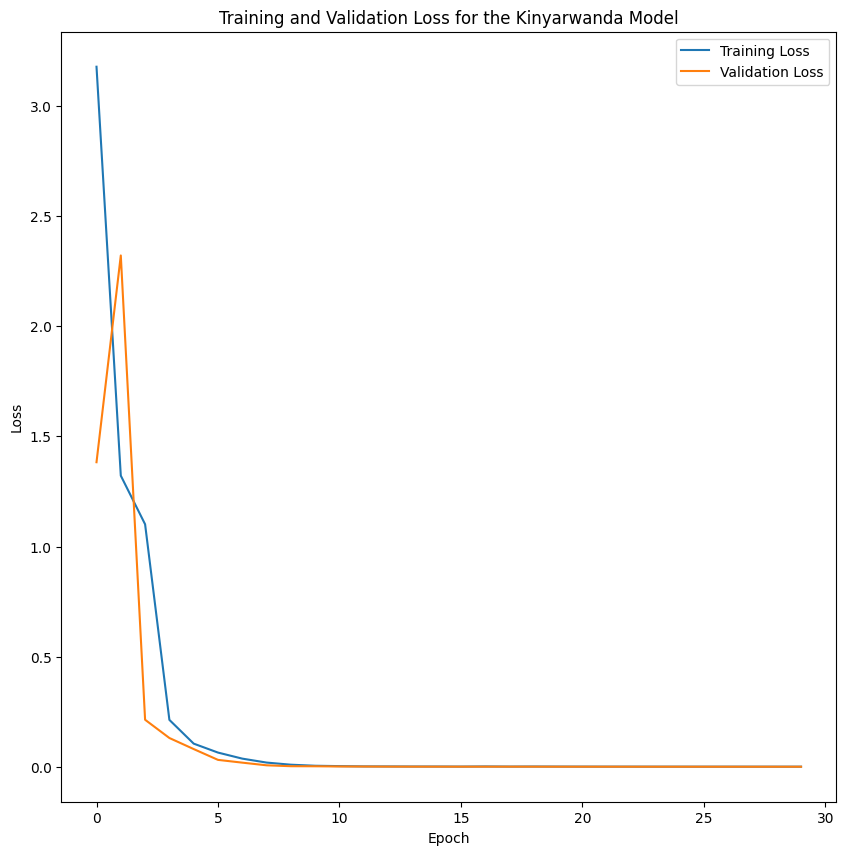

In [ ]:

# Plot the model's performance

# Create a figure with two subplots
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the training loss and validation loss on the same plot
ax.plot(train_losses, label='Training Loss')
ax.plot(val_losses, label='Validation Loss')

# Set the title, axis labels, and legend
ax.set_title('Training and Validation Loss for the Kinyarwanda Model')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

# Show the plot
plt.show()


### We show an example of how the cascading network works:

### The function below shows what the server side does: it receives embeddings, and provide predictions

In [ ]:
def inference_cloud(x_emb, y_emb,lx):
  device_server = 'cuda' if torch.cuda.is_available() else 'cpu'
  model_server = Transformer(input_size = 27, nhead = nhead, num_encoder_layers = num_encoder_layers,
                    num_decoder_layers = num_decoder_layers, max_len= 500).to(device_server)
  import os
  MODEL_CHECKPOINT_PATH = "/content/swahili_checkpoint.pth"
  if os.path.exists(MODEL_CHECKPOINT_PATH):
    load_model("/content/swahili_checkpoint.pth", model_server, 'valid_loss')
  h = model_server(x_emb, y_emb,lx, is_from_edge = True)
  return h


The code below in the next cells shows what the Edge device does:

In [ ]:
# The edge device gets the data, and loads them
val_loader_unshuffled = torch.utils.data.DataLoader(dataset = val_dataset, num_workers=2,
                                           batch_size =config['batch_size'],pin_memory=True, shuffle=False, collate_fn= val_dataset.collate_fn)#TODO


In [ ]:
# The edge device gets the data, and loads them to the model
# It then gets the embeddings, sends them to the server
# The server processes the embeddings and sends back the predictions
for i, data in enumerate(val_loader_unshuffled):

        x, y, lx, ly = data
        x = x[5].unsqueeze(dim=0)
        y = torch.tensor([[0]]) #y[0].unsqueeze(dim=0)
        lx = lx[0].unsqueeze(dim=0)
        x, y = x.to(device), y.to(device)
        for _ in range(50):
          with torch.inference_mode():
            # On edge device:
              x_emb, y_emb = model(x, y,lx, get_embeddings = True)
            #On server side:
              h = inference_cloud(x_emb, y_emb,lx) #model(x_emb, y_emb,lx, is_from_edge = True)
              h = torch.permute(h, (0, 2, 1))
              y = torch.cat([y, h.argmax(axis=1)[:,-1:].to(device)], dim = 1)
        # Send the output to the edge
        h_edge = h
        break

In [ ]:
# the predictions are however poor: just "aaaaaa"s only. We need further training, to make it more robust.
for batch_pred in h_edge.argmax(axis=1):
  pred_string = ""
  for idx in batch_pred:
    # print(idx.tolist())
    pred_string+= vocabulary[idx.tolist()]
  print(pred_string)

aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
